In [2]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import evaluate
import faiss
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
data = pd.read_csv('../../data/yelp/test_en_parallel.txt', sep='\t', header=None, skiprows=1)
data = data[[0, 1]]
data.columns = ['NEG', 'POS']

print(f"Total pairs: {len(data)}")
print(data.head())

neg_sentences = data['NEG'].values
pos_sentences = data['POS'].values

X_train, X_test, y_train, y_test = train_test_split(
    neg_sentences, pos_sentences, test_size=0.2, random_state=42
)

print(f"Train pairs: {len(X_train)}")
print(f"Test pairs: {len(X_test)}")

test_data = list(zip(X_test, y_test))

Total pairs: 1000
                                                 NEG  \
0  ever since joes has changed hands it's just go...   
1  there is definitely not enough room in that pa...   
2                  so basically tasted watered down.   
3  she said she'd be back and disappeared for a f...   
4  i can't believe how inconsiderate this pharmac...   

                                                 POS  
0  Ever since joes has changed hands it's gotten ...  
1    There is so much room in that part of the venue  
2              It didn't taste watered down at all.   
3  She said she'd be back, and didn't disappear a...  
4               This pharmacy is really considerate.  
Train pairs: 800
Test pairs: 200


In [5]:
kb_documents = []
for neg, pos in zip(X_train, y_train):
    kb_documents.append(neg)
    kb_documents.append(pos)

print(f"Total KB documents: {len(kb_documents)}")

Total KB documents: 1600


In [6]:
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
batch_size = 64
kb_embeddings = []

for i in tqdm(range(0, len(kb_documents), batch_size)):
    batch = kb_documents[i:i + batch_size]
    embeddings = embedding_model.encode(batch, show_progress_bar=False)
    kb_embeddings.append(embeddings)

kb_embeddings = np.vstack(kb_embeddings).astype('float32')
print(f"Embeddings shape: {kb_embeddings.shape}")

100%|██████████| 25/25 [00:00<00:00, 44.14it/s]

Embeddings shape: (1600, 384)


*FAISS for fast semantic similarity search over KB embeddings (with vector normalization)*

In [7]:
dimension = kb_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
faiss.normalize_L2(kb_embeddings)
index.add(kb_embeddings)
print(f"Index created with {index.ntotal} vectors")

Index created with 1600 vectors


In [8]:
def retrieve_context(query, top_k=5, similarity_threshold=0.5):
    query_embedding = embedding_model.encode([query], show_progress_bar=False).astype('float32')
    faiss.normalize_L2(query_embedding)

    distances, indices = index.search(query_embedding, top_k * 2)

    filtered_docs = []
    filtered_scores = []

    for dist, idx in zip(distances[0], indices[0]):
        if dist >= similarity_threshold:
            filtered_docs.append(kb_documents[idx])
            filtered_scores.append(dist)

        if len(filtered_docs) >= top_k:
            break

    return filtered_docs, filtered_scores

In [16]:
test_negative = test_data[0][0]
print(f"Test negative sentence: {test_negative}")
retrieved, scores = retrieve_context(test_negative, top_k=5)
print(f"Retrieved documents:")
for i, (doc, score) in enumerate(zip(retrieved, scores)):
    print(f"{i + 1}. (score: {score:.2f}) {doc[:100]}...")

Test negative sentence: Every experience has been awful.
Retrieved documents:
1. (score: 0.74) the experience was horrible...
2. (score: 0.64) i have had a bad experience every time from start to finish....
3. (score: 0.62) the experience was always the same...
4. (score: 0.60) I always have a good experience...
5. (score: 0.58) i have had a great experience every time from start to finish....


In [10]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMS

In [20]:
def create_prompt_with_rag(negative_sentence, context_docs=None):
    if context_docs is None or len(context_docs) == 0:
        # Zero-shot without context
        prompt = f"""Transform the following negative sentence into a positive sentence with the same meaning.

Negative sentence: {negative_sentence}

Positive version:"""
    else:
        # RAG with context
        context = '\n'.join([f"- {doc}" for doc in context_docs])
        prompt = f"""Use the following examples to transform the negative sentence into a positive sentence.

Context examples: {context}

Negative sentence: {negative_sentence}

Positive version:"""

    return prompt

In [21]:
def generate_answer(prompt, max_new_tokens=50):
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=2048,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    prompt_length = len(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
    generated_text = response[prompt_length:].strip()

    if '\n' in generated_text:
        generated_text = generated_text.split('\n')[0]

    for marker in ['Negative:', 'Negative sentence', 'Transform', 'Example']:
        if marker in generated_text:
            generated_text = generated_text.split(marker)[0]

    return generated_text.strip()

In [13]:
print(f"Test set length: {len(test_data)}")

n_samples = min(200, len(test_data))
test_data = test_data[:n_samples]
print(f"Testing data length: {len(test_data)}")

Test set length: 200
Testing data length: 200


In [14]:
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

In [23]:
context_sizes = [0, 3, 5, 10]
results = []

for n_context in context_sizes:
    print(f"Evaluating with {n_context} context documents")

    predictions = []
    references = []

    for i, (negative_sentence, correct_positive) in enumerate(tqdm(test_data, desc=f"{n_context}-context")):
        if n_context > 0:
            context_docs, _ = retrieve_context(negative_sentence, top_k=n_context, similarity_threshold=0.4)
        else:
            context_docs = None

        prompt = create_prompt_with_rag(negative_sentence, context_docs)
        generated_positive = generate_answer(prompt)

        predictions.append(generated_positive.lower())
        references.append(correct_positive.lower())

        if i < 5:
            print(f"Example {i+1}:")
            print(f"Negative: {negative_sentence[:80]}...")
            print(f"Generated: {generated_positive[:50]}...")
            print(f"Correct: {correct_positive[:50]}...")

    try:
        bleu_score = bleu.compute(
            predictions=predictions,
            references=[[r] for r in references],
            smooth=True
        )['bleu']
    except:
        bleu_score = 0.0

    try:
        bert_results = bertscore.compute(
            predictions=predictions,
            references=references,
            lang='en',
            model_type='roberta-large'
        )
        bert_f1 = float(np.mean(bert_results['f1']))
    except:
        bert_f1 = 0.0

    results.append({
        'n_context': n_context,
        'bleu': bleu_score,
        'bertscore_f1': bert_f1,
        'predictions': predictions,
        'references': references
    })

    print(f"{n_context} context documents:")
    print(f"BLEU: {bleu_score:.4f}")
    print(f"BERTScore F1: {bert_f1:.4f}")

Evaluating with 0 context documents


0-context:   0%|          | 1/200 [00:01<03:44,  1.13s/it]

Example 1:
Negative: Every experience has been awful....
Generated: Every experience has been a valuable learning oppo...
Correct: and every experience has been a positive one....


0-context:   1%|          | 2/200 [00:01<02:40,  1.24it/s]

Example 2:
Negative: This place is just terrible. ...
Generated: This place is just wonderful....
Correct: this place still kicks ass....


0-context:   2%|▏         | 3/200 [00:02<02:39,  1.23it/s]

Example 3:
Negative: it's not a gem worth searching out....
Generated: it's a gem worth searching out....
Correct: well worth searching out this gem....


0-context:   2%|▏         | 4/200 [00:04<04:01,  1.23s/it]

Example 4:
Negative: The outside seating is too packed, and happy hour never happens....
Generated: The outside seating is always bustling with happy ...
Correct: i love the outside seating and the reverse happy h...


0-context:   2%|▎         | 5/200 [00:05<04:00,  1.23s/it]

Example 5:
Negative: included in this price was a credit card fee and an after midnight fee....
Generated: this price includes a credit card fee and an after...
Correct: Included in this price was a small credit card fee...


0-context: 100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


0 context documents:
BLEU: 0.2169
BERTScore F1: 0.9224
Evaluating with 3 context documents


3-context:   0%|          | 1/200 [00:04<13:23,  4.04s/it]

Example 1:
Negative: Every experience has been awful....
Generated: Every experience has been unique and interesting....
Correct: and every experience has been a positive one....


3-context:   1%|          | 2/200 [00:07<12:56,  3.92s/it]

Example 2:
Negative: This place is just terrible. ...
Generated: This place has so much potential!...
Correct: this place still kicks ass....


3-context:   2%|▏         | 3/200 [00:11<13:00,  3.96s/it]

Example 3:
Negative: it's not a gem worth searching out....
Generated: it's a gem worth searching out....
Correct: well worth searching out this gem....


3-context:   2%|▏         | 4/200 [00:15<12:47,  3.91s/it]

Example 4:
Negative: The outside seating is too packed, and happy hour never happens....
Generated: The outside seating is spacious and often has happ...
Correct: i love the outside seating and the reverse happy h...


3-context:   2%|▎         | 5/200 [00:19<12:37,  3.88s/it]

Example 5:
Negative: included in this price was a credit card fee and an after midnight fee....
Generated: In addition to the initial price, we also offer a ...
Correct: Included in this price was a small credit card fee...


3-context: 100%|██████████| 200/200 [11:54<00:00,  3.57s/it]


3 context documents:
BLEU: 0.2101
BERTScore F1: 0.9189
Evaluating with 5 context documents


5-context:   0%|          | 1/200 [00:03<12:26,  3.75s/it]

Example 1:
Negative: Every experience has been awful....
Generated: Every experience has been great....
Correct: and every experience has been a positive one....


5-context:   1%|          | 2/200 [00:07<12:39,  3.84s/it]

Example 2:
Negative: This place is just terrible. ...
Generated: This place has so much potential!...
Correct: this place still kicks ass....


5-context:   2%|▏         | 3/200 [00:11<12:29,  3.80s/it]

Example 3:
Negative: it's not a gem worth searching out....
Generated: it's a gem worth searching out....
Correct: well worth searching out this gem....


5-context:   2%|▏         | 4/200 [00:15<12:42,  3.89s/it]

Example 4:
Negative: The outside seating is too packed, and happy hour never happens....
Generated: The outside seating is always bustling with activi...
Correct: i love the outside seating and the reverse happy h...


5-context:   2%|▎         | 5/200 [00:19<12:32,  3.86s/it]

Example 5:
Negative: included in this price was a credit card fee and an after midnight fee....
Generated: In addition to the initial price, we also offer a ...
Correct: Included in this price was a small credit card fee...


5-context: 100%|██████████| 200/200 [11:36<00:00,  3.48s/it]


5 context documents:
BLEU: 0.2145
BERTScore F1: 0.9185
Evaluating with 10 context documents


10-context:   0%|          | 1/200 [00:03<13:10,  3.97s/it]

Example 1:
Negative: Every experience has been awful....
Generated: Every experience has been great....
Correct: and every experience has been a positive one....


10-context:   1%|          | 2/200 [00:07<12:50,  3.89s/it]

Example 2:
Negative: This place is just terrible. ...
Generated: This place is just great!...
Correct: this place still kicks ass....


10-context:   2%|▏         | 3/200 [00:11<12:39,  3.86s/it]

Example 3:
Negative: it's not a gem worth searching out....
Generated: it's a gem worth searching out....
Correct: well worth searching out this gem....


10-context:   2%|▏         | 4/200 [00:15<12:44,  3.90s/it]

Example 4:
Negative: The outside seating is too packed, and happy hour never happens....
Generated: The outside seating is always bustling with activi...
Correct: i love the outside seating and the reverse happy h...


10-context:   2%|▎         | 5/200 [00:19<12:30,  3.85s/it]

Example 5:
Negative: included in this price was a credit card fee and an after midnight fee....
Generated: In addition to the initial price, we also offer a ...
Correct: Included in this price was a small credit card fee...


10-context: 100%|██████████| 200/200 [11:24<00:00,  3.42s/it]


10 context documents:
BLEU: 0.2125
BERTScore F1: 0.9185


In [24]:
results_df = pd.DataFrame(results)
print("FINAL RESULTS")
print(results_df[['n_context', 'bleu', 'bertscore_f1']].to_string(index=False))

FINAL RESULTS
 n_context     bleu  bertscore_f1
         0 0.216856      0.922438
         3 0.210114      0.918920
         5 0.214549      0.918524
        10 0.212478      0.918470


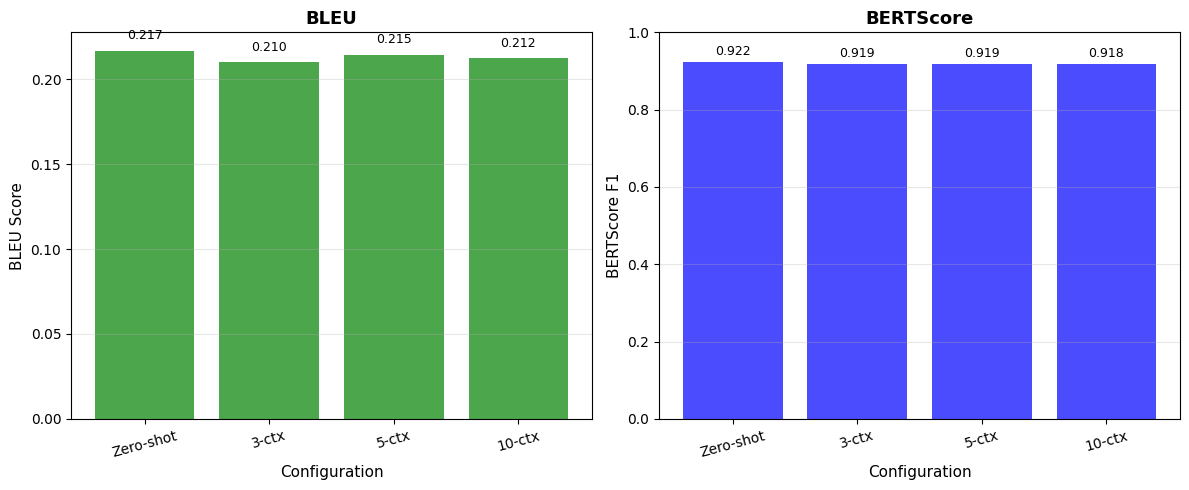

BEST CONFIGURATION
Context documents: 0
BLEU: 0.2169
BERTScore F1: 0.9224


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(results_df))
labels = [f"{int(n)}-ctx" if n > 0 else "Zero-shot" for n in results_df['n_context']]

# BLEU
axes[0].bar(x, results_df['bleu'], color='green', alpha=0.7)
axes[0].set_xlabel('Configuration', fontsize=11)
axes[0].set_ylabel('BLEU Score', fontsize=11)
axes[0].set_title('BLEU', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=15)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['bleu']):
    axes[0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# BERTScore
axes[1].bar(x, results_df['bertscore_f1'], color='blue', alpha=0.7)
axes[1].set_xlabel('Configuration', fontsize=11)
axes[1].set_ylabel('BERTScore F1', fontsize=11)
axes[1].set_title('BERTScore', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=15)
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['bertscore_f1']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

best_config = results_df.loc[results_df['bertscore_f1'].idxmax()]
print("BEST CONFIGURATION")
print(f"Context documents: {int(best_config['n_context'])}")
print(f"BLEU: {best_config['bleu']:.4f}")
print(f"BERTScore F1: {best_config['bertscore_f1']:.4f}")

#### DistilRoBERTa

In [27]:
embedding_model_2 = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

In [28]:
kb_embeddings_2 = []
for i in tqdm(range(0, len(kb_documents), batch_size)):
    batch = kb_documents[i:i + batch_size]
    embeddings = embedding_model_2.encode(batch, show_progress_bar=False)
    kb_embeddings_2.append(embeddings)

kb_embeddings_2 = np.vstack(kb_embeddings_2).astype('float32')
print(f"Embeddings shape: {kb_embeddings_2.shape}")

100%|██████████| 25/25 [00:00<00:00, 33.17it/s]

Embeddings shape: (1600, 768)


In [29]:
dimension_2 = kb_embeddings_2.shape[1]
index_2 = faiss.IndexFlatIP(dimension_2)
faiss.normalize_L2(kb_embeddings_2)
index_2.add(kb_embeddings_2)
print(f"Index created with {index_2.ntotal} vectors")

Index created with 1600 vectors


In [31]:
def retrieve_context_2(query, top_k=5):
    query_embedding = embedding_model_2.encode([query], show_progress_bar=False).astype('float32')
    faiss.normalize_L2(query_embedding)
    distances, indices = index_2.search(query_embedding, top_k)
    retrieved_docs = [kb_documents[idx] for idx in indices[0]]
    return retrieved_docs, distances[0]

In [43]:
best_n_context = int(best_config['n_context'])

if best_n_context == 0:
    best_n_context = 3
    print(f"Forcing {best_n_context} context documents for meaningful comparison")

print(f"Evaluating DistilRoBERTa with {best_n_context} context documents")

print(f"Testing on {len(test_data)} samples:")

predictions_2 = []
references_2 = []

for i, (negative_sentence, correct_positive) in enumerate(tqdm(test_data, desc=f"DistilRoBERTa-{best_n_context}")):
    if best_n_context > 0:
        context_docs, _ = retrieve_context_2(negative_sentence, top_k=best_n_context)
    else:
        context_docs = None

    prompt = create_prompt_with_rag(negative_sentence, context_docs)
    generated_positive = generate_answer(prompt)

    predictions_2.append(generated_positive.lower())
    references_2.append(correct_positive.lower())

Forcing 3 context documents for meaningful comparison
Evaluating DistilRoBERTa with 3 context documents
Testing on 200 samples:


DistilRoBERTa-3: 100%|██████████| 200/200 [12:55<00:00,  3.88s/it]


In [44]:
try:
    bleu_score_2 = bleu.compute(predictions=predictions_2, references=[[r] for r in references_2], smooth=True)['bleu']
except:
    bleu_score_2 = 0.0

try:
    bert_results_2 = bertscore.compute(predictions=predictions_2, references=references_2, lang='en')
    bert_f1_2 = float(np.mean(bert_results_2['f1']))
except:
    bert_f1_2 = 0.0

print("DistilRoBERTa Results:")
print(f"BLEU: {bleu_score_2:.4f}")
print(f"BERTScore F1: {bert_f1_2:.4f}")

DistilRoBERTa Results:
BLEU: 0.2100
BERTScore F1: 0.9194


Comparison between the best MiniLM (zero-shot) and 3-ctx DistilRoBERTa

In [46]:
comparison_df = pd.DataFrame([
    {'Model': 'MiniLM', 'BLEU': best_config['bleu'], 'BERTScore': best_config['bertscore_f1']},
    {'Model': 'DistilRoBERTa', 'BLEU': bleu_score_2, 'BERTScore': bert_f1_2}
])
print(comparison_df)

           Model      BLEU  BERTScore
0         MiniLM  0.216856   0.922438
1  DistilRoBERTa  0.209995   0.919368


MiniLM (3-ctx): BLEU 0.210114, BERTscore:0.918920

*If using 0-context comparison:*

Model:MiniLM, BLEU: 0.216856, BERTScore: 0.922438
Model:DistilRoBERTa, BLEU: 0.216856, BERTScore: 0.922438

##### Conclusion

The results show that zero-shot prompting achieved the best performance for sentiment transformation, with 0.22 BLEU and 0.92 BERTScore. Adding retrieved context actually degraded performance, for example, the 3-ctx achieved 0.21 BLEU and 0.919 BERTScore. Using 5 and 10 documents gave similar results, showing that RAG does not help for this task.
One possible problems is that the knowledge base uses training samples from the same dataset, so the retrieved sentences have a very similar style to test cases. This makes the model copy specific phrases instead of creating natural transformations. Another thing is that LLaMA-2 handles sentiment reversal well with just its pretrained knowledge. The context examples limit the model's creativity instead of helping it. Both MiniLM-L6-v2 and DistilRoBERTa-v1 got nearly identical results with 3 context documents (both models retrieve similar examples from the same knowledge base, but the quality of examples does not matter much for this task). However, zero-shot LLaMA-2 shows good results without any fine-tuning and the high BERTScore shows that even though exact wording differs, the model captures the right sentiment and meaning.